In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Zenith_DrugScreening/

/content/drive/MyDrive/Zenith_DrugScreening


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Load_Ethogram import ListExpe,FishTable,add_hierarchical_level
#from .Load_Ethogram import Fish
from Fish import Fish
#from TrajectoryPreprocessing import TrajectoryPreprocessing
from utils import find_onset_offset_numpy
from utils import diff_but_better
from scipy.signal import savgol_filter


In [ ]:
FishTable

,expe_name,path,name_of_experiment,setup,roi,date,time,drug_concentration,age,pixel_size,fps,width,height,file_signature
0,DrugScreening_hal00_20211111_1301,Data/DrugScreening,DrugScreening,hal,0,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
1,DrugScreening_hal01_20211111_1301,Data/DrugScreening,DrugScreening,hal,1,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
2,DrugScreening_hal02_20211111_1301,Data/DrugScreening,DrugScreening,hal,2,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
3,DrugScreening_hal03_20211111_1301,Data/DrugScreening,DrugScreening,hal,3,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
4,DrugScreening_hal04_20211111_1301,Data/DrugScreening,DrugScreening,hal,4,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
5,DrugScreening_hal05_20211111_1301,Data/DrugScreening,DrugScreening,hal,5,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
6,DrugScreening_hal06_20211111_1301,Data/DrugScreening,DrugScreening,hal,6,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
7,DrugScreening_hal07_20211111_1301,Data/DrugScreening,DrugScreening,hal,7,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
8,DrugScreening_hal08_20211111_1301,Data/DrugScreening,DrugScreening,hal,8,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt
9,DrugScreening_hal09_20211111_1301,Data/DrugScreening,DrugScreening,hal,9,20211111,1301,NONE,8,116.067444,400,2336,1728,000_camlog.txt


In [ ]:
# Mapping between ROI and Drug:

Drugs = ['eth','eth','eth','eth','eth',
'ctr','ctr','ctr','ctr','ctr','eth','eth','eth','eth','eth',
'ctr','ctr','ctr','ctr','ctr'
]
print(len(Drugs))

dr_list =[]
for i in range(len(FishTable)):
    dr_list = dr_list + [Drugs[i]]
id_fish = np.argsort(dr_list)
print(np.array(Drugs)[id_fish])


20
['ctr' 'ctr' 'ctr' 'ctr' 'ctr' 'ctr' 'ctr' 'ctr' 'ctr' 'ctr' 'eth' 'eth'
 'eth' 'eth' 'eth' 'eth' 'eth' 'eth' 'eth' 'eth']


In [ ]:
def compute_kinematic(camlog):

    x = camlog.mideye_x_cart*fish.pixel_size/1000
    y = camlog.mideye_y_cart*fish.pixel_size/1000

    angle = camlog.body_angle_cart
    angle = np.arctan2(np.sin(angle),np.cos(angle))
    angle = np.unwrap(angle)

    x = savgol_filter(x[:-1],101,2)
    y = savgol_filter(y[:-1],101,2)
    angle = savgol_filter(angle[:-1],101,2)

    angular_speed = diff_but_better(angle,dt=1/400,filter_length=75)
    speed=np.sqrt(diff_but_better(x,dt=1/400,filter_length=75)**2+diff_but_better(y,dt=1/400,filter_length=75)**2)

    speed[np.isnan(speed)] = 0
    angular_speed[np.isnan(angular_speed)] = 0
    speed = np.array([0]+speed.tolist())
    angular_speed = np.array([0]+angular_speed.tolist())

    return x,y,angle,speed,angular_speed

In [ ]:
MatSpeed_LightOff = np.zeros((0,400*60))
MatSpeed_ApproachingDot = np.zeros((0,400*60))
MatAngularSpeed_LightOff = np.zeros((0,400*60))
MatAngularSpeed_ApproachingDot = np.zeros((0,400*60))

for i in id_fish:
    
    fish = Fish(FishTable.iloc[i])
    dr = Drugs[FishTable.iloc[i].roi]
    camlog = fish.load_mat_camlog()
    
    x,y,angle,speed,angular_speed = compute_kinematic(camlog)
    shader_id = camlog.shader_id.values
    # 30 sec before/ 30 sec after:
    onset,offset,duration = find_onset_offset_numpy(shader_id==1)
    for on_,off_ in zip(onset,offset):
        MatSpeed_LightOff = np.vstack((MatSpeed_LightOff,speed[on_-400*30:on_+400*30]))
        MatAngularSpeed_LightOff = np.vstack((MatAngularSpeed_LightOff,angle[on_-400*30:on_+400*30]-angle[on_]))

    onset,offset,duration = find_onset_offset_numpy(shader_id==2)
    for on_,off_ in zip(onset,offset):
        MatSpeed_ApproachingDot = np.vstack((MatSpeed_ApproachingDot,speed[on_-400*30:on_+400*30]))
        MatAngularSpeed_ApproachingDot = np.vstack((MatAngularSpeed_ApproachingDot,angular_speed[on_-400*30:on_+400*30]))




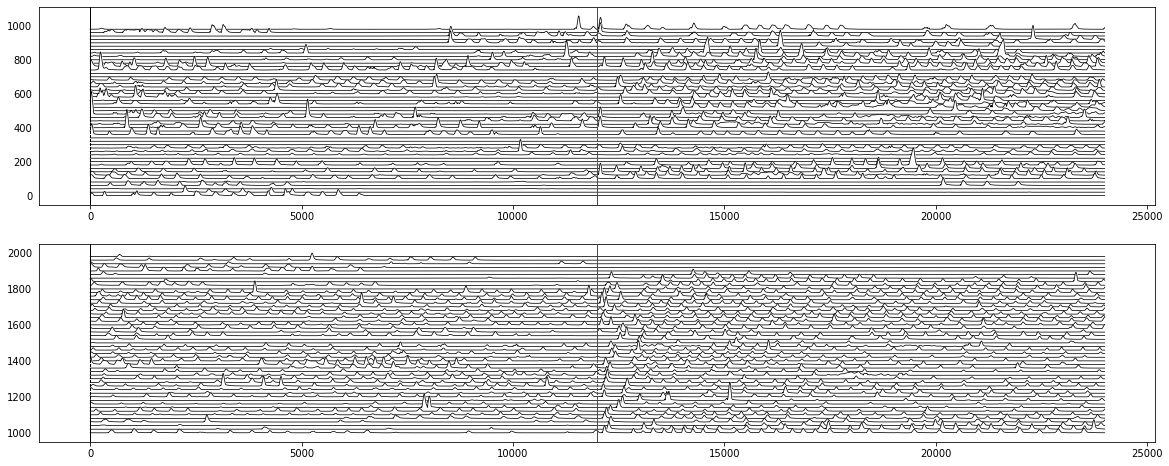

In [ ]:
import matplotlib as mpl

cmap = mpl.cm.get_cmap("Spectral")
fig = plt.figure(figsize=(20, 8))
ax = plt.subplot(2, 1,1)
for i in range(50):

    Y = MatSpeed_LightOff[i,:]
    X = np.arange(len(Y))
    ax.plot(X, Y + i*20, color="k", linewidth=0.75, zorder=100 - i)
    color = cmap(i / 50)
    ax.fill_between(X, Y + i*20, 20*i, color='white', zorder=100 - i)
    ax.yaxis.set_tick_params(tick1On=False)
    ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
    ax.axvline(400*30, ls="--", lw=0.75, color="r", zorder=250)

ax = plt.subplot(2, 1,2)
for i in range(50,100):

    Y = MatSpeed_LightOff[i,:]
    X = np.arange(len(Y))
    ax.plot(X, Y + i*20, color="k", linewidth=0.75, zorder=100 - i)
    color = cmap(i / 50)
    ax.fill_between(X, Y + i*20, 20*i, color='white', zorder=100 - i)
    ax.yaxis.set_tick_params(tick1On=False)
    ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
    ax.axvline(400*30, ls="--", lw=0.75, color="r", zorder=250)



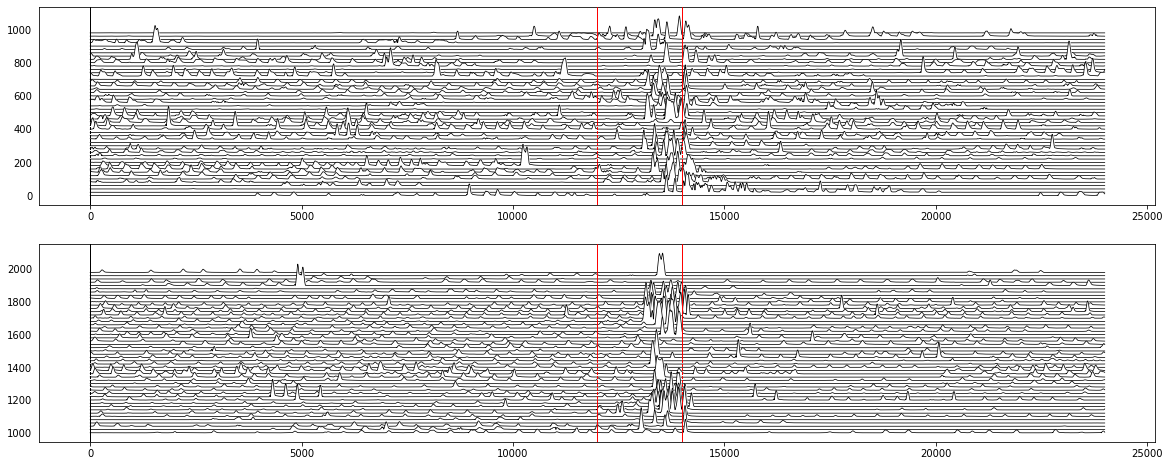

In [ ]:
import matplotlib as mpl

cmap = mpl.cm.get_cmap("Spectral")
fig = plt.figure(figsize=(20, 8))
ax = plt.subplot(2, 1,1)
for i in range(50):

    Y = MatSpeed_ApproachingDot[i,:]
    X = np.arange(len(Y))
    ax.plot(X, Y + i*20, color="k", linewidth=0.75, zorder=100 - i)
    color = cmap(i / 50)
    ax.fill_between(X, Y + i*20, 20*i, color='white', zorder=100 - i)
    ax.yaxis.set_tick_params(tick1On=False)
    ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
    ax.axvline(400*30, ls="--", lw=0.75, color="r", zorder=250)
    ax.axvline(400*35, ls="--", lw=0.75, color="r", zorder=250)

ax = plt.subplot(2, 1,2)
for i in range(50,100):

    Y = MatSpeed_ApproachingDot[i,:]
    X = np.arange(len(Y))
    ax.plot(X, Y + i*20, color="k", linewidth=0.75, zorder=100 - i)
    color = cmap(i / 50)
    ax.fill_between(X, Y + i*20, 20*i, color='white', zorder=100 - i)
    ax.yaxis.set_tick_params(tick1On=False)
    ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
    ax.axvline(400*30, ls="--", lw=0.75, color="r", zorder=250)
    ax.axvline(400*35, ls="--", lw=0.75, color="r", zorder=250)

